In [37]:
import os
from os import listdir
from os.path import isfile, join
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import statistics
from skimage import filters as flt
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi


from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [38]:
# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

import segment_image as si
from segment_image import is_RGB

In [39]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from skimage.color import rgb2gray, rgb2hsv
from skimage import io, color, filters, segmentation, exposure, morphology, util
from skimage.segmentation import watershed
from skimage.filters import sobel, roberts, laplace
from scipy import ndimage as ndi
from skimage import filters as flt 
from skimage.segmentation import flood, flood_fill
import cv2 

from skimage.util import img_as_float
from eda_helper import sideBside

In [40]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg' #9L-59_10x.jpg'
image = io.imread(fname)

In [41]:
gray = rgb2gray(image[:1700])

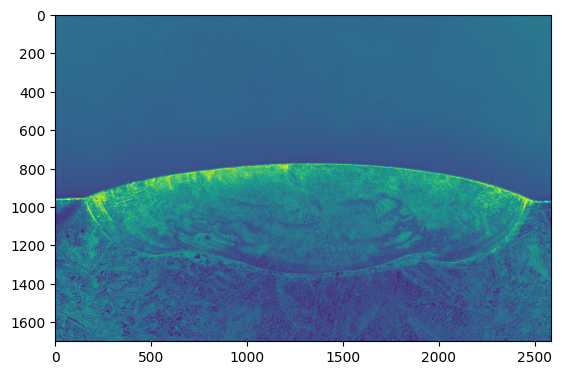

In [42]:
plt.imshow(gray)

In [43]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg'

img_large   = cv2.imread(fname)

In [44]:
# take the cropping values from crop_image function

img = img_large[:1700]

### Edge reconstruction algorithm based on extrapolation of continuous lines:

$i$. Preprocess image: 7 first steps of Laplace transform + Sobel edge
<br>$ii$. Identify reference line: at $x = x_0 = 50$ identify the global maximum of the 2nd derivative and the local maximum to its right.
<br>$iii$. Do a Gaussian curve fit on each of the two maxima (2nd derivative) with the following initial guess:

- mean ($\mu$) = maximum (peak) position
- sigma ($\sigma$)= the distance between the two maxima/4
- height ($h$)= the 2nd derivative on the maximum 

<br>$iv$. Record the fit parameters for $x_0$.
<br>
<br>The left and right peaks correspond to the top and bottom edges of the ROI.
<br>For each peak the following algorithm takes place:

1. Plot the line profile of the next line $x=x+1$.
2. Take only the region of $\mu-(n*\sigma) < y < \mu + (n*\sigma)$, where $n=5$ (to be optimized)
3. Do a Gaussian curve fit on the (2nd derivative) with initial guess parameters taken from the values of the former line ($x-1$).
4. Record the fit parameters for $x$.
5. Repeat steps 1-4.

 

In [10]:
def laplace_sobel(img: np.ndarray, blur_area: int =71, blur_sigma: int=0,
                  laplace_ksize: int=1, laplace_scale: int=1, laplace_delta: int=0,
                  sobel_dx: int=0, sobel_dy: int =1, sobel_ksize: int=5,
                  sobel_blur_area: int =5)->np.ndarray:
    """Procedure for Laplace transform and Sobel edge detection.

    Args:
        img (np.ndarray): RGB image
        blur_area (int, optional): area parameter of cv2.GaussianBlur. Defaults to 71.
        blur_sigma (int, optional): sigma parameter of cv2.GaussianBlur. Defaults to 0.
        laplace_ksize (int, optional): ksize parameter of cv2.Laplacian. Defaults to 1.
        laplace_scale (int, optional): scale parameter of cv2.Laplacian. Defaults to 1.
        laplace_delta (int, optional): delta parameter of cv2.Laplacian. Defaults to 0.
        sobel_dx (int, optional): dx parameter of cv2.sobel. Defaults to 0.
        sobel_dy (int, optional): dy parameter of cv2.sobel. Defaults to 1.
        sobel_ksize (int, optional): ksize parameter of cv2.sobel. Defaults to 5.
        sobel_blur_area (int, optional): area parameter of cv2.blur on the sobel output . Defaults to 5.

    Returns:
        np.ndarray: processed image after laplace transform and Sobel edge detection.
    """
    
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grayscale = cv2.GaussianBlur(img_grayscale, 
                                     (blur_area, blur_area), blur_sigma)
    
    #step 1
    edge_laplace = cv2.Laplacian(img_grayscale, -1, ksize=laplace_ksize, 
                                 scale=laplace_scale, delta=laplace_delta,
                                 borderType=cv2.BORDER_DEFAULT)
    
    #step 2 add original image and laplace
    new_image = img_grayscale + edge_laplace
    
    #step 3 sobel gradient on original image
    sobel=cv2.Sobel(img_grayscale, cv2.CV_64F, sobel_dx, sobel_dy,
                    ksize=sobel_ksize)

    #step 4 mean blur
    mean_blur = cv2.blur(sobel, (sobel_blur_area, sobel_blur_area))

    #step 5
    new_image_dot_mean_blur = cv2.multiply(new_image, mean_blur,dtype=cv2.CV_64F)
    
    #step 6
    final_image = img_grayscale + new_image_dot_mean_blur
    
    
    return final_image
    

In [11]:
processed = laplace_sobel(img)

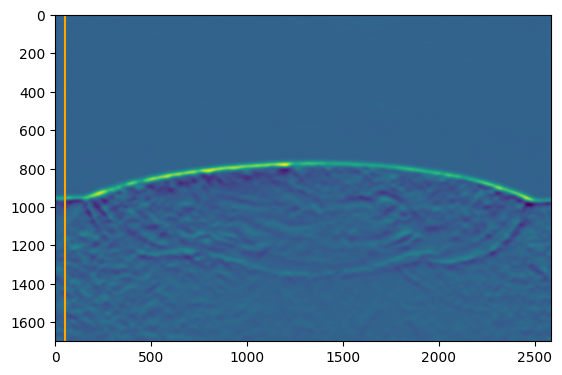

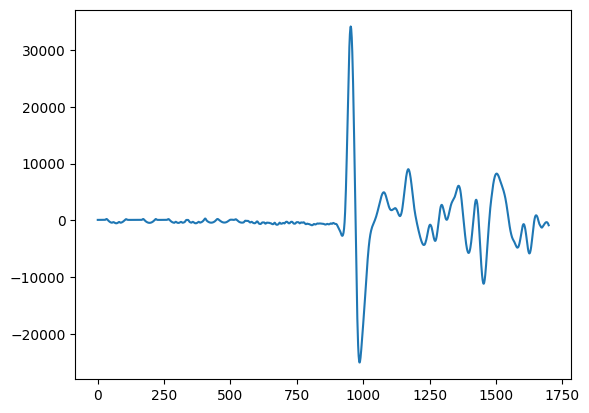

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


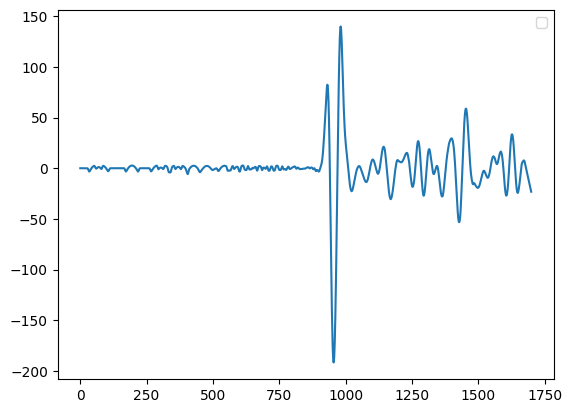

In [20]:
xline = 50
plt.imshow(processed)
plt.axvline(xline,color='orange')
plt.show()

sav_0d_nni = savgol_filter(img_as_float(processed)[:,xline], 51, 3, deriv=0) 

sav_2d_nni = savgol_filter(img_as_float(processed)[:,xline], 51, 3, deriv=2) 

plt.plot(sav_0d_nni)
plt.show()
plt.plot(sav_2d_nni)
plt.legend()
plt.show()

In [39]:
# Step ii)
global_minimum = np.where(sav_2d_nni == sav_2d_nni.min())[0][0]
global_minimum


955

In [40]:
peaks, _ = find_peaks(sav_2d_nni)
peaks_dist = peaks - global_minimum
print(peaks_dist)
peak_top = global_minimum + peaks_dist[np.where(peaks_dist < 0)].max()
peak_bottom = global_minimum + peaks_dist[np.where(peaks_dist > 0)].min()
print(peak_top)
print(peak_bottom)

[-930 -903 -885 -868 -815 -760 -713 -667 -651 -634 -618 -603 -586 -569
 -528 -478 -443 -412 -394 -381 -364 -343 -323 -313 -306 -295 -280 -263
 -251 -234 -213 -203 -194 -184 -171 -148 -136 -123 -115 -110  -97  -84
  -73  -63  -24   26   96  147  188  241  276  318  360  389  444  498
  529  566  602  630  672  716]
931
981


In [44]:
def find_start_maxima(savgol_2nd: np.array)->tuple:
    """_summary_

    Args:
        savgol_2nd (np.array): 2nd derivative savgol line-profile

    Returns:
        peak_top, peak_bottom (tuple): the index of the top and bottom
                                       2nd derivative maxima 
    """
    global_minimum = np.where(savgol_2nd == savgol_2nd.min())[0][0]
    peaks, _ = find_peaks(savgol_2nd)
    peaks_dist = peaks - global_minimum
    peak_top = global_minimum + peaks_dist[np.where(peaks_dist < 0)].max()
    peak_bottom = global_minimum + peaks_dist[np.where(peaks_dist > 0)].min()
    return peak_top, peak_bottom

In [43]:
from scipy.optimize import curve_fit
from scipy import asarray as exp


In [45]:
savgol_2nd = sav_2d_nni


In [54]:


mean_0 = peak_top
sigma_0 = (peak_bottom-peak_top)/4
h_0 = savgol_2nd[peak_top]
n = 3
def gauss(x, h, mu, sigma):
    return h*exp(-(x-mu)**2/(2*sigma**2))
x = range(peak_top-int(n*sigma_0), peak_top+int(n*sigma_0))
popt,pcov = curve_fit(gauss,x,savgol_2nd[x],p0=[h_0, mean_0, sigma_0])

plt.plot(savgol_2nd,'b.:',label='data')
plt.plot(x,gauss(x,*popt),'r.:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

/home/dan_s/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
  


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


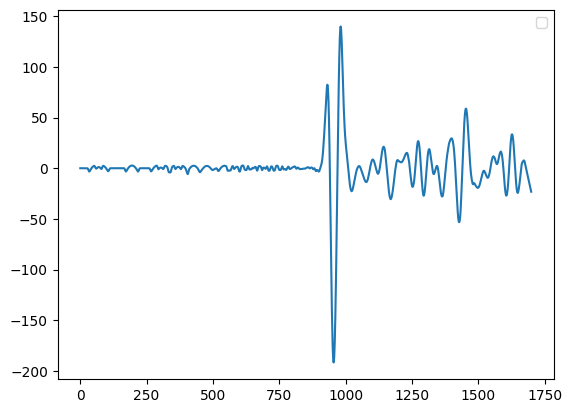

In [42]:

plt.plot(sav_2d_nni)
plt.legend()
plt.show()

# Trying producing a canny edge detection from basic principles

In [12]:
from scipy import ndimage


In [13]:


#Detemine gradient function for Fx and Fy using sobel filter(normlized)
def gradient(img, axis: str='x') :
    grad_matrix = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
    if axis == 'x':
        grad_img = ndimage.convolve(img, grad_matrix)
    elif axis == 'y':
        grad_img = ndimage.convolve(img, grad_matrix.transpose())
    return grad_img/np.max(grad_img)


#Define gradient magnitude function
def gradient_magnitude(gx, gy) :
    magnitude = np.hypot(gx, gy)
    return magnitude/np.max(magnitude)


# Find the closest direciton
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
         
    return closest_dir_arr


#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output)   

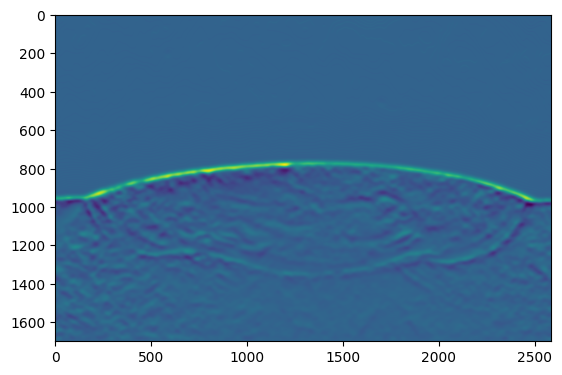

In [14]:
plt.imshow(processed)

In [15]:

#Convert the image to grayscale
# gray_input_img = rgb2gray(processed)


In [16]:

#Apply gaussian blurring
blur_img = flt.gaussian(processed, sigma = 1.0)


In [17]:

#Find gradient Fx
x_grad = gradient(processed)

#Find gradient Fy
y_grad = gradient(processed, axis='y')


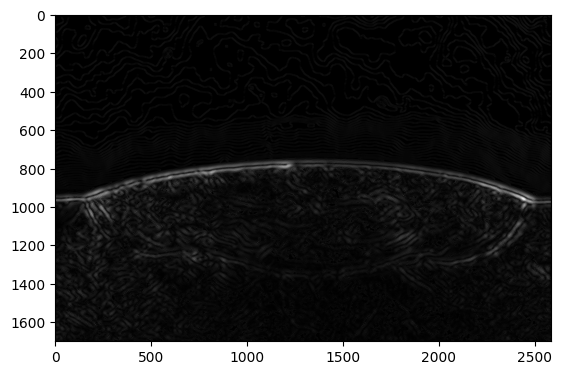

In [18]:

#Compute edge strength
grad_mag = gradient_magnitude(x_grad, y_grad)
plt.imshow(grad_mag, cmap = plt.get_cmap('gray'))
plt.show()



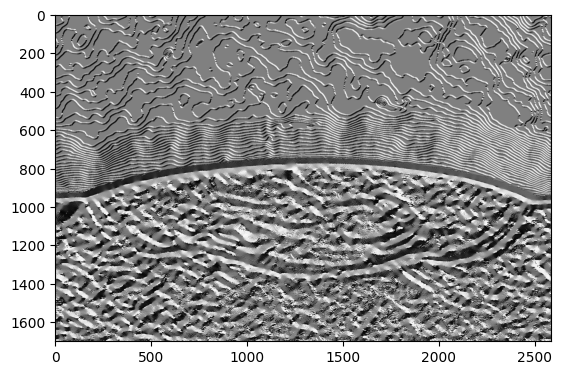

In [19]:
#Compute direction of gradient
grad_dir = np.degrees(np.arctan2(y_grad, x_grad))
plt.imshow(grad_dir, cmap = plt.get_cmap('gray'))
plt.show()

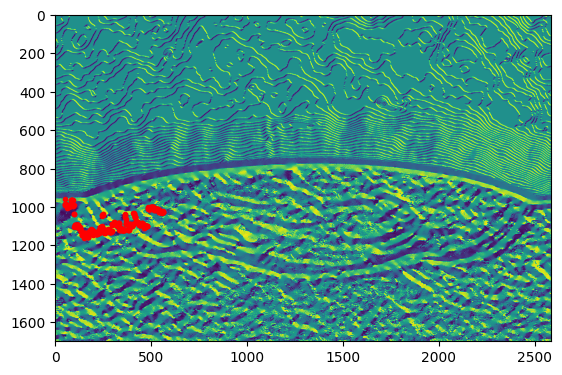

In [35]:
x=50
y=960
# delta = 1
# x_2 = x + delta
# y_2 = y + np.tan(grad_dir[y,x])*(delta)
# print([x_2, y_2])
plt.imshow(grad_dir)
xs = [x]
ys = [y]
delta=1
i=1
while x < 1000 and i < 500:
    y_2 = y + np.tan(grad_dir[int(y),x])*(delta*i) 
    x_2 = x + delta
    if abs(y_2-y) < 500:
        i = 1
        y, x = y_2, x_2
        xs.append(x)
        ys.append(y)
    else:
        i += 1 
plt.scatter(xs, ys, marker='.', color='red')


plt.show()


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure()

x=120
y=960
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
delta = 1

    
plt.show()

KeyboardInterrupt: 

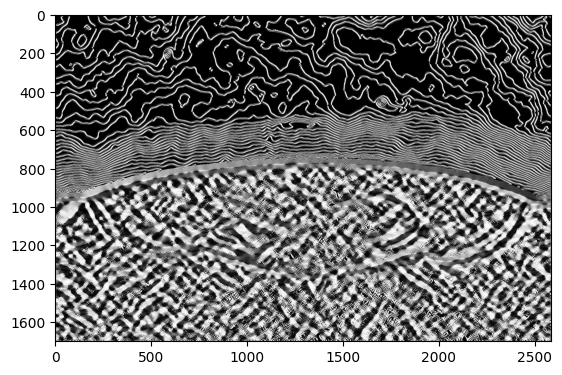

In [49]:
plt.imshow(np.abs(grad_dir), cmap = plt.get_cmap('gray'))
plt.show()

(array([1537632.,  407889.,  313528.,  234634.,  200457.,  261290.,
         239214.,  313063.,  407609.,  477484.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <BarContainer object of 10 artists>)

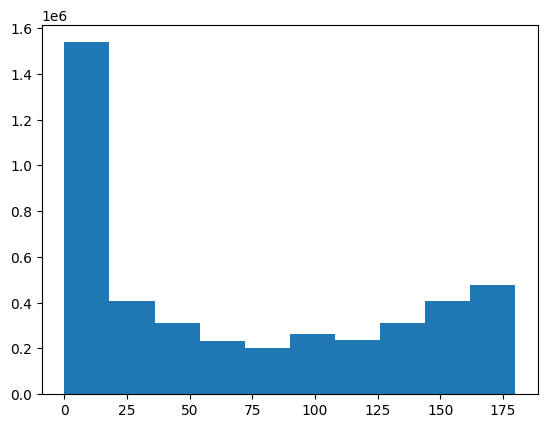

In [50]:
from skimage.exposure import histogram

plt.hist(abs(grad_dir.flatten()))

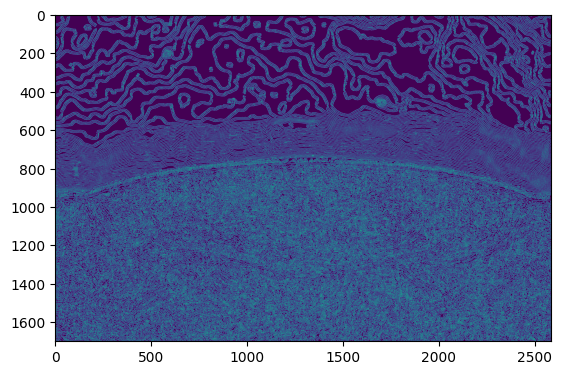

In [51]:
from skimage.feature import canny
edges_image = canny(grad_dir, low_threshold=25/255, high_threshold=75/255)
plt.imshow(edges_image)

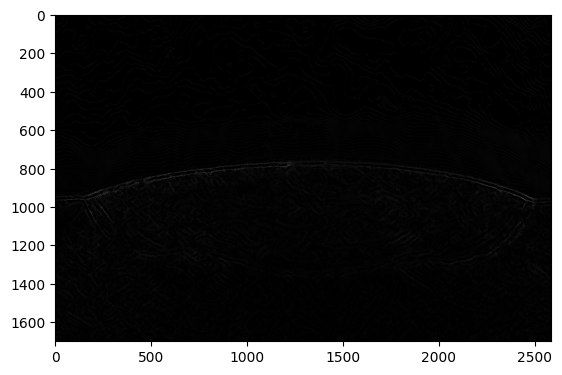

In [41]:
#Phase 2 : Non maximal suppression
closest_dir = closest_dir_function(grad_dir)
thinned_output = non_maximal_suppressor(grad_mag, closest_dir)
plt.imshow(thinned_output, cmap = plt.get_cmap('gray'))
plt.show()

In [52]:
#This cell contains all the used functionsfor Phase III

#Function to include weak pixels that are connected to chain of strong pixels 
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

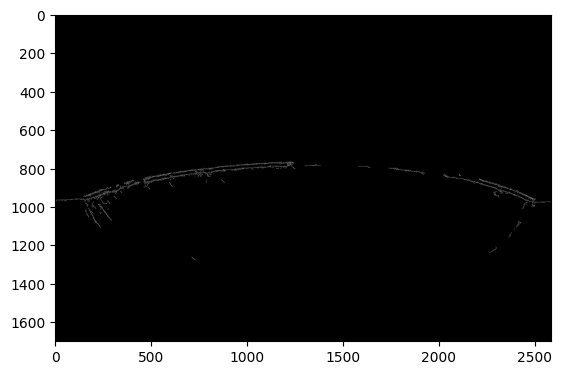

In [53]:
output_img = hysteresis_thresholding(thinned_output)
plt.imshow(output_img, cmap = plt.get_cmap('gray'))
plt.show()

In [55]:
low = 0.1
high = 0.35
lowt = (thinned_output > low).astype(int)
hight = (thinned_output > high).astype(int)
hyst = flt.apply_hysteresis_threshold(thinned_output, low, high)

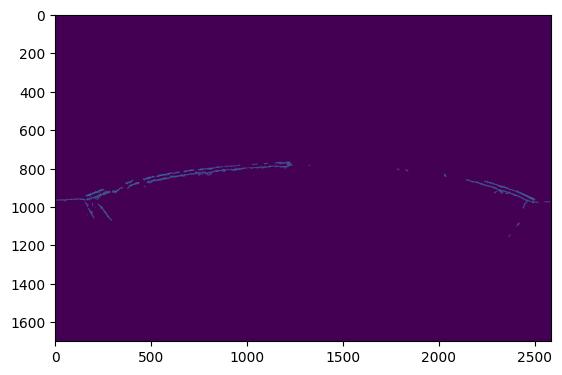

In [56]:
plt.imshow(hyst)
plt.show()